In [22]:
import pandas as pd
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
#stopwords.words('english')

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors


from time import time 
from collections import defaultdict

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [23]:
df_tweets = pd.read_csv("ncr_moretweets.csv", encoding='utf-8')
df_tweets = df_tweets[df_tweets['label'] != 0]

In [24]:
def text_to_word_list(text, tagalog_letters):
    ''' Pre process and convert texts to a list of words 
    method inspired by method from eliorc github repo: https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb'''
    text = tagalog_letters(text)
    text = str(text)
    text = text.lower()

    # Clean the text
    text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    text = sub(r"http\S.*$"," ", text) # removing twitter urls
    text = sub(r"\+", " plus ", text)
    text = sub(r",", " ", text)
    text = sub(r"\.", " ", text)
    text = sub(r"!", " ! ", text)
    text = sub(r"\?", " ? ", text)
    text = sub(r"'", "", text)
    text = sub(r":", " : ", text)
    text = sub(r"\s{2,}", " ", text)
    
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
        
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
        
    text = [word for word in text.split(' ') if word not in stopwords.words('english')]
    text = ' '.join(text)
    
    return text

In [25]:
df_tweets.tweets = df_tweets.tweets.apply(lambda x: text_to_word_list(x, unidecode))

In [26]:
import nltk
nltk.download('punkt')

def preprocess(df_tweets):
    df_tweets['document_sentences'] = df_tweets.tweets.str.split('.') 
    df_tweets['tokenized_sentences'] = list(map(lambda sentences: list(map(nltk.word_tokenize, sentences)), df_tweets.document_sentences))  
    df_tweets['tokenized_sentences'] = list(map(lambda sentences: list(filter(lambda lst: lst, sentences)), df_tweets.tokenized_sentences))

preprocess(df_tweets)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Intel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
df_tweets.head()

,tweets,label,document_sentences,tokenized_sentences
0,awit sa kilala kong nag positive sa covid tas ...,-1,[awit sa kilala kong nag positive sa covid tas...,"[[awit, sa, kilala, kong, nag, positive, sa, c..."
2,yung dinaan na lang sa pagkain yung pagkamiss ...,-1,[yung dinaan na lang sa pagkain yung pagkamiss...,"[[yung, dinaan, na, lang, sa, pagkain, yung, p..."
5,literally miss going without using facemask sh...,-1,[literally miss going without using facemask s...,"[[literally, miss, going, without, using, face..."
6,goddamn covid rip sekou smith influence writin...,-1,[goddamn covid rip sekou smith influence writi...,"[[goddamn, covid, rip, sekou, smith, influence..."
8,sobrang delikado ng ginawa mo kahit saang band...,-1,[sobrang delikado ng ginawa mo kahit saang ban...,"[[sobrang, delikado, ng, ginawa, mo, kahit, sa..."


In [28]:
from sklearn.model_selection import train_test_split
train, test, y_train, y_test = train_test_split(df_tweets.drop(columns='label'), df_tweets['label'], test_size=.2)

In [29]:
#Collecting a vocabulary
voc = []
for sentence in train.tokenized_sentences:
    voc.extend(sentence)

print("Number of sentences: {}.".format(len(voc)))
print("Number of rows: {}.".format(len(train)))

Number of sentences: 172.
Number of rows: 172.


In [30]:
from gensim.models import word2vec, Word2Vec

num_features = 300    
min_word_count = 3    
num_workers = 4       
context = 8           
downsampling = 1e-3   

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=voc, sg=1, hs=0, workers=num_workers, size=num_features, min_count=min_word_count, window=context,
                    sample=downsampling, negative=5, iter=6)

INFO - 21:16:34: collecting all words and their counts
INFO - 21:16:34: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 21:16:34: collected 1131 word types from a corpus of 2265 raw words and 172 sentences
INFO - 21:16:34: Loading a fresh vocabulary
INFO - 21:16:34: effective_min_count=3 retains 138 unique words (12% of original 1131, drops 993)
INFO - 21:16:34: effective_min_count=3 leaves 1115 word corpus (49% of original 2265, drops 1150)
INFO - 21:16:34: deleting the raw counts dictionary of 1131 items
INFO - 21:16:34: sample=0.001 downsamples 138 most-common words
INFO - 21:16:34: downsampling leaves estimated 513 word corpus (46.1% of prior 1115)
INFO - 21:16:34: estimated required memory for 138 words and 300 dimensions: 400200 bytes
INFO - 21:16:34: resetting layer weights
INFO - 21:16:34: training model with 4 workers on 138 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=8
INFO - 21:16:34: worker thread finished; awaiting f

In [31]:
%%time
def sentence_vectors(model, sentence):
    #Collecting all words in the text
#     print(sentence)
    sent_vector = np.zeros(model.vector_size, dtype="float32")
    if sentence == [[]] or sentence == []  :
        return sent_vector
    words=np.concatenate(sentence)
#     words = sentence
    #Collecting words that are known to the model
    model_voc = set(model.wv.vocab.keys()) 
#     print(len(model_voc))

    # Use a counter variable for number of words in a text
    nwords = 0
    # Sum up all words vectors that are know to the model
    for word in words:
        if word in model_voc: 
            sent_vector += model[word]
            nwords += 1.
    # Now get the average
    if nwords > 0:
        sent_vector /= nwords
    return sent_vector

Wall time: 0 ns


In [32]:
train['sentence_vectors'] = list(map(lambda sen_group:
                                      sentence_vectors(W2Vmodel, sen_group),
                                      train.tokenized_sentences))
test['sentence_vectors'] = list(map(lambda sen_group:
                                    sentence_vectors(W2Vmodel, sen_group), 
                                    test.tokenized_sentences))

<timed exec>:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [33]:
def vectors_to_feats(df, ndim):
    index=[]
    for i in range(ndim):
        df[f'w2v_{i}'] = df['sentence_vectors'].apply(lambda x: x[i])
        index.append(f'w2v_{i}')
    return df[index]
X_train = vectors_to_feats(train, 300)
X_train.head()

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,w2v_290,w2v_291,w2v_292,w2v_293,w2v_294,w2v_295,w2v_296,w2v_297,w2v_298,w2v_299
220,0.001662,-0.000558,-0.001580,0.002575,0.001074,0.001473,-0.001629,0.001627,-0.001247,-0.000145,...,-0.002064,-0.000671,-0.000789,0.002318,-0.000751,0.000884,-0.001356,-0.003034,-0.002209,-0.000175
17,0.000640,-0.000352,-0.001446,0.002784,0.000367,0.002807,-0.001788,0.001167,-0.001169,-0.000922,...,-0.002205,-0.000836,-0.000339,0.002824,-0.000612,0.000716,-0.001917,-0.002921,-0.001949,-0.000975
64,0.001413,-0.000302,-0.002147,0.002583,0.000463,0.002643,-0.002090,0.001400,-0.001509,-0.000107,...,-0.002253,-0.000593,-0.000611,0.003172,-0.001022,0.000790,-0.001601,-0.003197,-0.002047,-0.000613
310,0.001517,-0.000693,-0.002178,0.003019,0.000395,0.003253,-0.002250,0.001414,-0.001535,0.000343,...,-0.002636,-0.000814,-0.000029,0.003228,-0.000951,0.000914,-0.001656,-0.003794,-0.001811,-0.000512
194,0.000732,-0.000574,-0.001334,0.002810,0.000332,0.002180,-0.001844,0.000858,-0.001429,-0.000287,...,-0.002410,-0.000215,-0.000531,0.002910,-0.001138,0.001919,-0.001333,-0.002621,-0.001941,-0.000677


In [34]:
%%time
test['sentence_vectors'] = list(map(lambda sen_group:sentence_vectors(W2Vmodel, sen_group), test.tokenized_sentences))
X_test=vectors_to_feats(test, 300)

<timed exec>:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Wall time: 189 ms


In [35]:
from sklearn.ensemble import GradientBoostingClassifier
g_boost = GradientBoostingClassifier()
g_boost.fit(X_train, y_train)
y_pred = g_boost.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.6976744186046512
Testing F1 score: 0.6507662721306925


In [36]:
from sklearn.metrics import roc_auc_score, confusion_matrix
roc_auc_score(y_test,g_boost.predict_proba(X_test)[:,1])

0.571236559139785

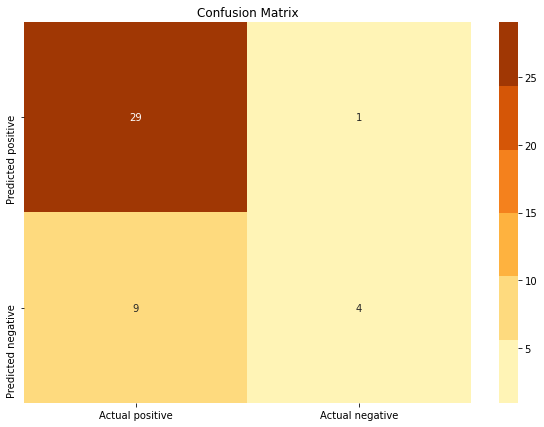

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(confusion_matrix(y_test,g_boost.predict(X_test)), index = ['Predicted positive', 'Predicted negative'],
                  columns = ['Actual positive', 'Actual negative'])
test= sns.color_palette('YlOrBr')
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap=test)
plt.title('Confusion Matrix')
plt.show()

In [38]:
voc_df = []
for sentence_group in df_tweets.tokenized_sentences:
    voc_df.extend(sentence_group)

print("Number of sentences: {}.".format(len(voc_df)))
print("Number of texts: {}.".format(len(df_tweets)))

Number of sentences: 215.
Number of texts: 215.


In [39]:
from gensim.models import word2vec, Word2Vec

num_features = 300    
min_word_count = 3    
num_workers = 4       
context = 8           
downsampling = 1e-3   

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=voc_df, sg=1, hs=0, workers=num_workers, size=num_features, min_count=min_word_count, window=context,
                    sample=downsampling, negative=5, iter=6)

INFO - 21:16:37: collecting all words and their counts
INFO - 21:16:37: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 21:16:37: collected 1356 word types from a corpus of 2879 raw words and 215 sentences
INFO - 21:16:37: Loading a fresh vocabulary
INFO - 21:16:37: effective_min_count=3 retains 181 unique words (13% of original 1356, drops 1175)
INFO - 21:16:37: effective_min_count=3 leaves 1535 word corpus (53% of original 2879, drops 1344)
INFO - 21:16:37: deleting the raw counts dictionary of 1356 items
INFO - 21:16:37: sample=0.001 downsamples 79 most-common words
INFO - 21:16:37: downsampling leaves estimated 794 word corpus (51.8% of prior 1535)
INFO - 21:16:37: estimated required memory for 181 words and 300 dimensions: 524900 bytes
INFO - 21:16:37: resetting layer weights
INFO - 21:16:37: training model with 4 workers on 181 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=8
INFO - 21:16:37: worker thread finished; awaiting f

In [40]:
%%time
df_tweets['sentence_vectors'] = list(map(lambda sen_group: sentence_vectors(W2Vmodel, sen_group), df_tweets.tokenized_sentences))
df_tweets = vectors_to_feats(df_tweets, 300)
y = pd.read_csv('ncr_moretweets.csv', encoding='utf-8')
y = y[y['label'] != 0]
y = y['label'].values

<timed exec>:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Wall time: 218 ms


In [41]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
cv = ShuffleSplit(n_splits=5, random_state=1)

cv_score = cross_val_score(g_boost, df_tweets, y ,cv=cv, scoring='roc_auc')
print(cv_score)
print(cv_score.mean())
#df_tweets

[0.80701754 0.52777778 0.4957265  0.60952381 0.46666667]
0.5813424587108799


In [42]:
# Importing Classifier Modules
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import numpy as np
import matplotlib.pyplot as plt
!pip install mglearn
import mglearn
import pandas as pd
import pylab as plot
!pip install lmfit
import lmfit as lf
import seaborn as sns
import random
import os
import time
from pandas import Series
from math import sqrt
%matplotlib inline

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC, LinearSVC, LinearSVR
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
stratk_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

from sklearn.model_selection import GridSearchCV
param_grids = {'learning_rate': [.2, 0.1, 0.01, 0.05, 0.02, 0.01],
              'max_depth': [3, 4, 6, 10, 14, 16, 18, 20, 40, 60, 80, 100],
              'min_samples_leaf': [2, 3, 4],
              'n_estimators': [100, 200, 300, 400, 500],
              'max_features': [.5,.3, .2] 
}   

In [90]:
#new_df = classification(df_tweets, y)
new_df = pd.read_csv('word2vec_optimized.csv', index_col=0)
new_df = new_df.drop(columns=['f1', 'precision', 'recall'])

In [126]:
import ast 
knn_c = KNeighborsClassifier(n_jobs=-1)
log_res_l1 = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear', n_jobs=-1)
log_res_l2 = LogisticRegression(penalty='l2', max_iter=1000, solver='lbfgs', n_jobs=-1)
lin_svc_l1 = LinearSVC(penalty='l1', dual=False, max_iter=10000)
lin_svc_l2 = LinearSVC(penalty='l2', max_iter=10000)
nsvm_rbf = SVC(kernel='rbf')
d_tree = DecisionTreeClassifier(random_state=0)
r_forest = RandomForestClassifier(random_state=0)
g_boost = GradientBoostingClassifier(random_state=0)
    

model_dict = {
    'KNN': knn_c,
    'Logistic Regression (L1)': log_res_l1,
    'Logistic Regression (L2)': log_res_l2,
    'Linear SVM (L1)': lin_svc_l1,
    'Linear SVM (L2)': lin_svc_l2,
    'NonLinear SVM (RBF)': nsvm_rbf,
    'Decision Tree': d_tree,
    'Random Forest': r_forest,
    'XGBoost': g_boost
}

X_train, X_test, y_train, y_test = train_test_split(df_tweets, y, stratify=y, test_size=0.2, random_state=0)
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import ast

def calculate_scores(row):
    current_model = model_dict[row['Model']]
    current_model.set_params(**ast.literal_eval(row['Best Parameters']))
    current_model.fit(X_train, y_train)
    predictions = current_model.predict(X_test)
    row['f1 weighted'] = f1_score(y_test, predictions, average='weighted')
    row['f1 micro'] = f1_score(y_test, predictions, average='micro')
    row['f1 macro'] = f1_score(y_test, predictions, average='macro')
    

    df_cm = pd.DataFrame(confusion_matrix(y_test, predictions), index = ['Predicted positive', 'Predicted negative'],
                  columns = ['Actual positive', 'Actual negative'])
    colors = sns.color_palette('YlOrBr')
    plt.figure(figsize = (24,12))
    sns.heatmap(df_cm, annot=True, cmap=colors)
    plt.title('Confusion Matrix for ' + row['Model'])
    plt.show()
    newplt.savefig('images/' + row['Model'] + ' ' + 'confusion_matrix.png')
    return row
    

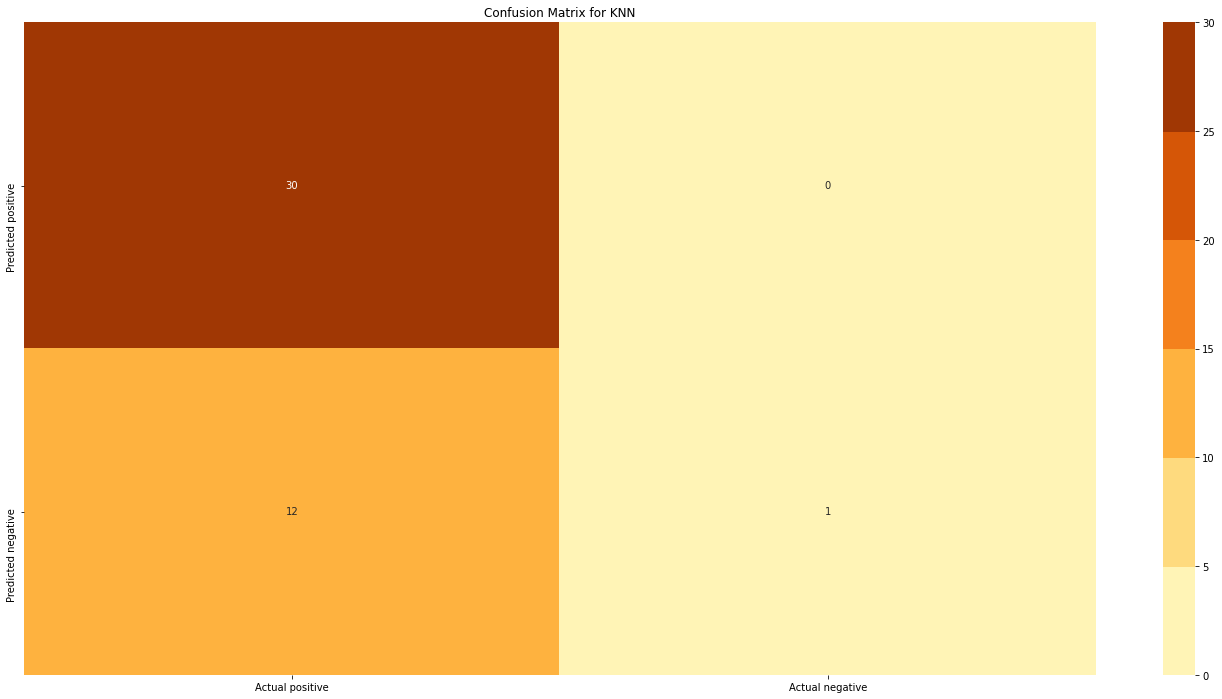

D:\OtherSoftware\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


<Figure size 432x288 with 0 Axes>

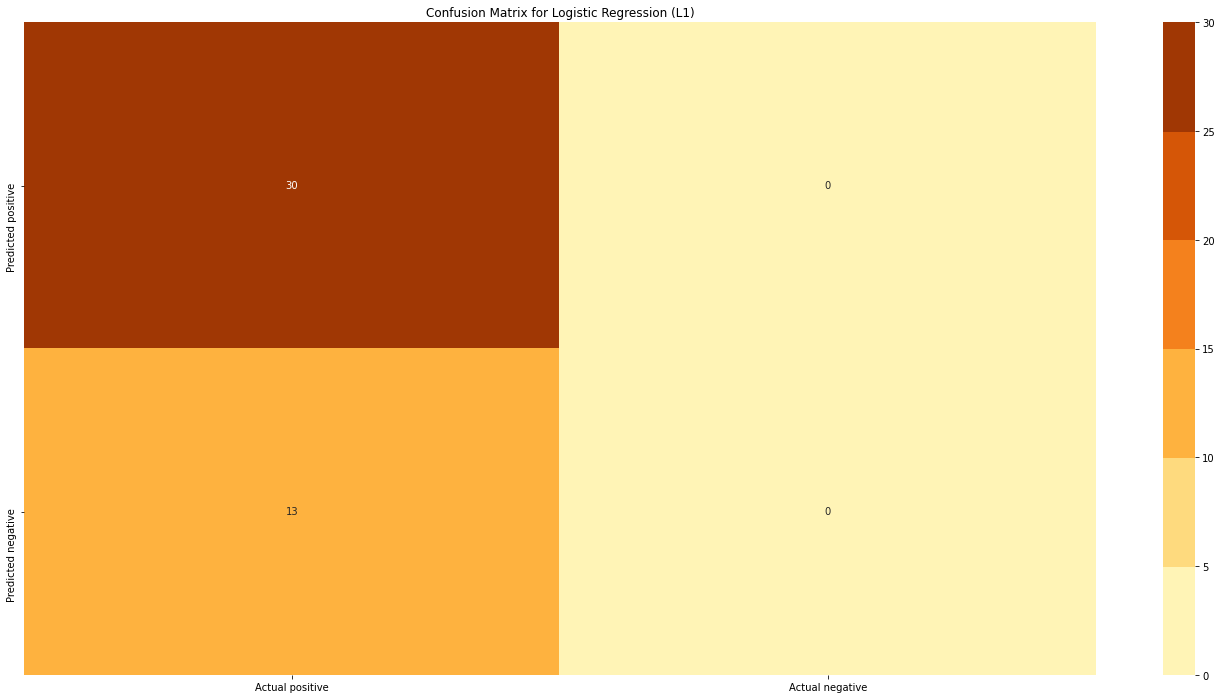

<Figure size 432x288 with 0 Axes>

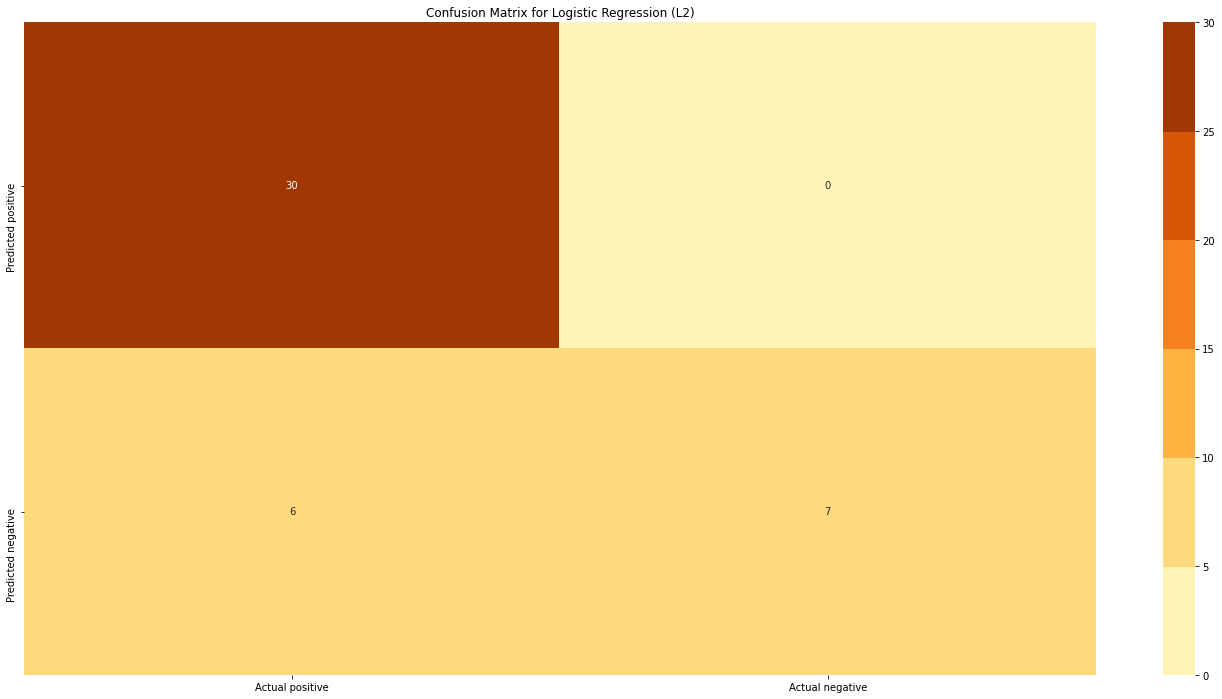

D:\OtherSoftware\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


<Figure size 432x288 with 0 Axes>

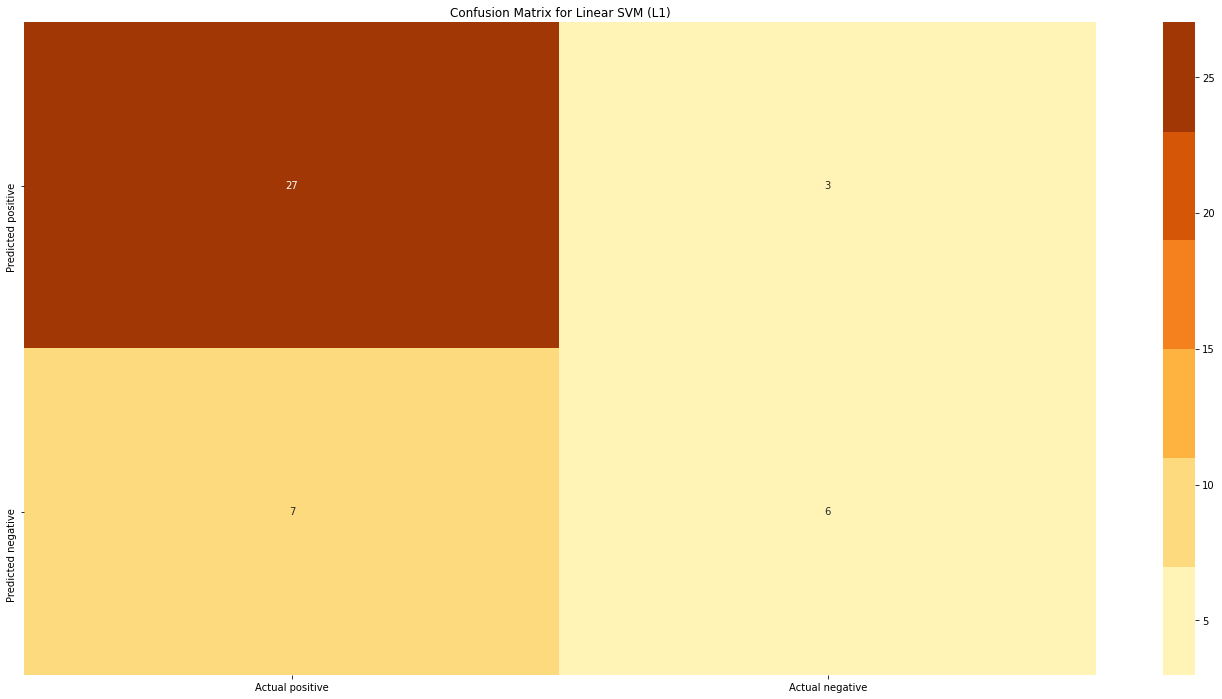

D:\OtherSoftware\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


<Figure size 432x288 with 0 Axes>

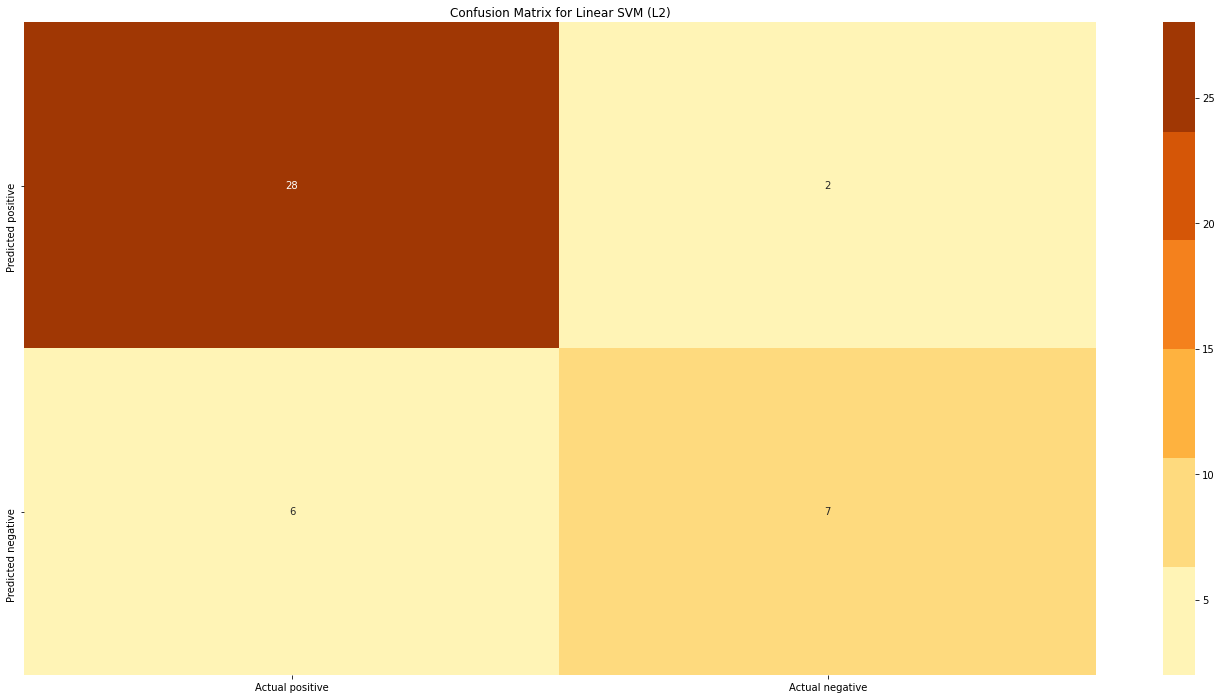

<Figure size 432x288 with 0 Axes>

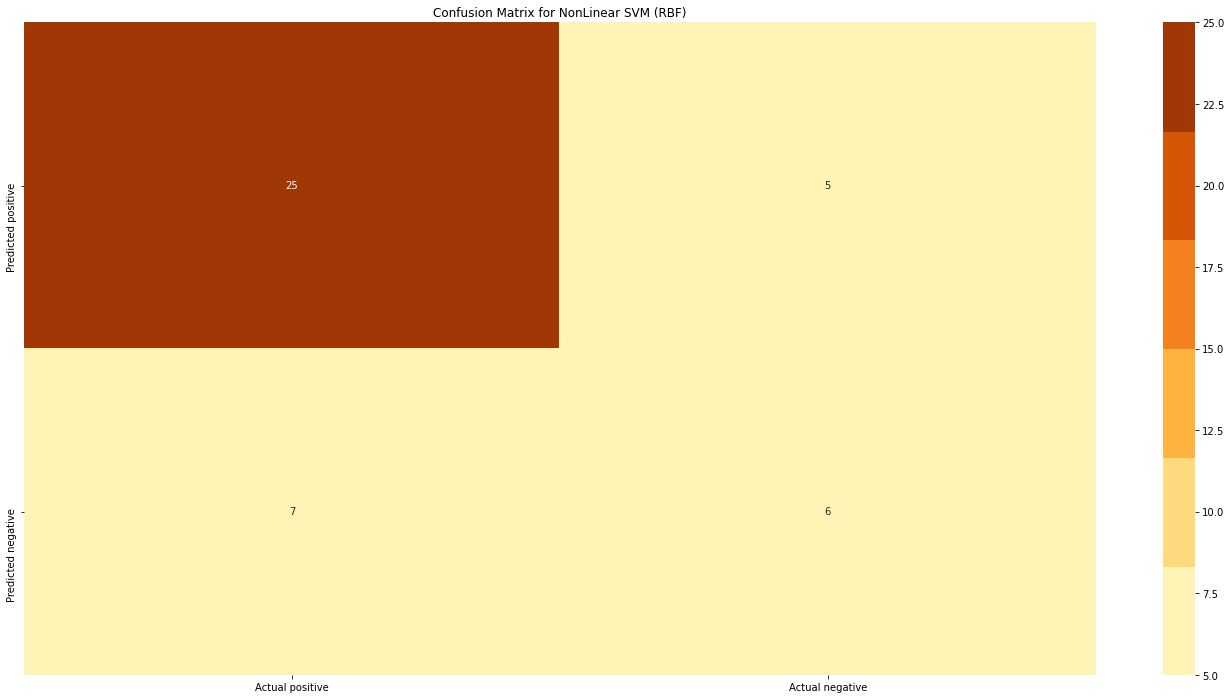

<Figure size 432x288 with 0 Axes>

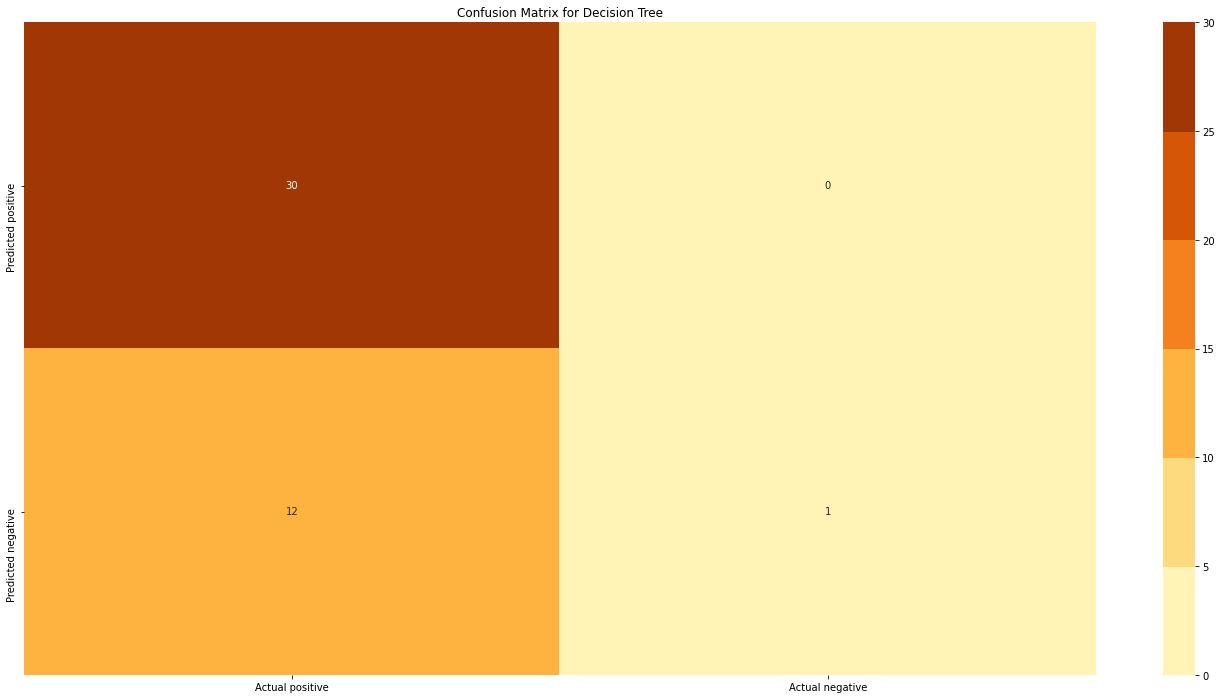

<Figure size 432x288 with 0 Axes>

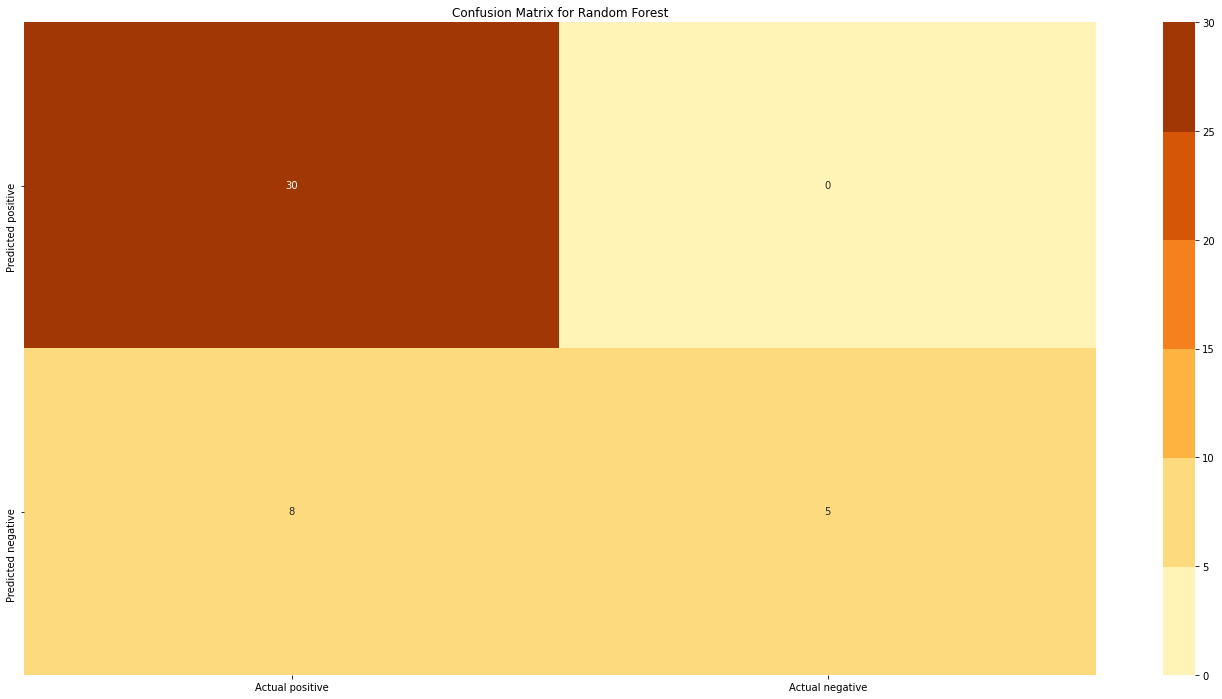

<Figure size 432x288 with 0 Axes>

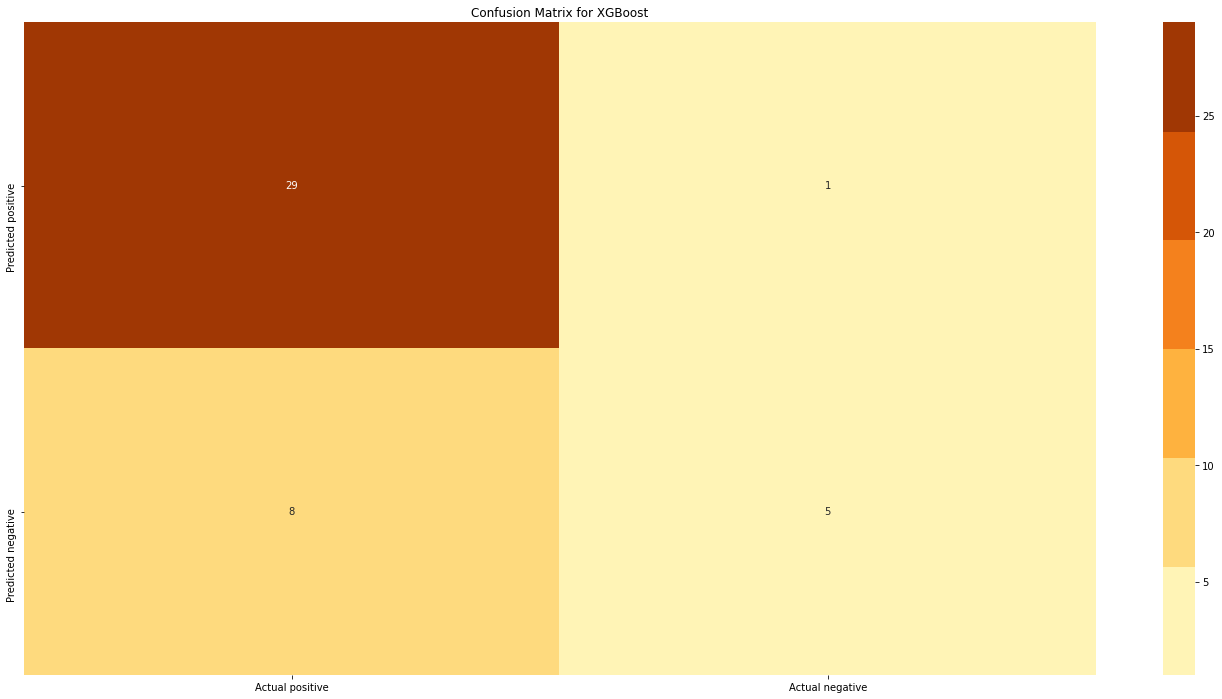

<Figure size 432x288 with 0 Axes>

In [127]:
new_df['Model'] = new_df.index
stats_df = new_df.apply(lambda row: calculate_scores(row), axis=1)

In [117]:
stats_df

,Test Accuracy,Training Accuracy,Best Parameters,Run Time,percent of PCC,Model,f1 weighted,f1 micro,f1 macro,Figures
KNN,0.720930,0.761628,{'n_neighbors': 4},5.382352,1.246960,KNN,0.624585,0.720930,0.488095,<module 'matplotlib.pyplot' from 'D:\\OtherSof...
Logistic Regression (L1),0.697674,0.697674,{'C': 1e-10},1.886265,1.206735,Logistic Regression (L1),0.573431,0.697674,0.410959,<module 'matplotlib.pyplot' from 'D:\\OtherSof...
Logistic Regression (L2),0.837209,0.848837,{'C': 54555.947811685146},1.935442,1.448082,Logistic Regression (L2),0.845877,0.860465,0.804545,<module 'matplotlib.pyplot' from 'D:\\OtherSof...
Linear SVM (L1),0.813953,0.970930,{'C': 428.13323987193957},5.957663,1.407858,Linear SVM (L1),0.753568,0.767442,0.694602,<module 'matplotlib.pyplot' from 'D:\\OtherSof...
Linear SVM (L2),0.790698,0.784884,{'C': 4832.930238571752},7.937805,1.367633,Linear SVM (L2),0.845877,0.860465,0.804545,<module 'matplotlib.pyplot' from 'D:\\OtherSof...
NonLinear SVM (RBF),0.674419,0.994186,"{'C': 37.92690190732238, 'gamma': 4832.9302385...",6.377883,1.166511,NonLinear SVM (RBF),0.713803,0.720930,0.653226,<module 'matplotlib.pyplot' from 'D:\\OtherSof...
Decision Tree,-0.145191,0.137483,{'max_depth': 1},2.241006,-0.251131,Decision Tree,0.624585,0.720930,0.488095,<module 'matplotlib.pyplot' from 'D:\\OtherSof...
Random Forest,0.767442,0.994186,"{'max_depth': 7, 'n_estimators': 100}",342.197690,1.327409,Random Forest,0.783554,0.813953,0.718954,<module 'matplotlib.pyplot' from 'D:\\OtherSof...
XGBoost,0.744186,0.994186,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",5370.757274,1.287184,XGBoost,0.763076,0.790698,0.695994,<module 'matplotlib.pyplot' from 'D:\\OtherSof...


In [47]:
#stats_df.to_csv('word2vec_optimized.csv')

In [48]:
new_df

,Test Accuracy,Training Accuracy,Best Parameters,Run Time,percent of PCC,Model
KNN,0.720930,0.761628,{'n_neighbors': 4},5.382352,1.246960,KNN
Logistic Regression (L1),0.697674,0.697674,{'C': 1e-10},1.886265,1.206735,Logistic Regression (L1)
Logistic Regression (L2),0.837209,0.848837,{'C': 54555.947811685146},1.935442,1.448082,Logistic Regression (L2)
Linear SVM (L1),0.813953,0.970930,{'C': 428.13323987193957},5.957663,1.407858,Linear SVM (L1)
Linear SVM (L2),0.790698,0.784884,{'C': 4832.930238571752},7.937805,1.367633,Linear SVM (L2)
NonLinear SVM (RBF),0.674419,0.994186,"{'C': 37.92690190732238, 'gamma': 4832.9302385...",6.377883,1.166511,NonLinear SVM (RBF)
Decision Tree,-0.145191,0.137483,{'max_depth': 1},2.241006,-0.251131,Decision Tree
Random Forest,0.767442,0.994186,"{'max_depth': 7, 'n_estimators': 100}",342.197690,1.327409,Random Forest
XGBoost,0.744186,0.994186,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",5370.757274,1.287184,XGBoost


In [49]:
from sklearn.ensemble import GradientBoostingClassifier
g_boost = GradientBoostingClassifier()
g_boost.fit(X_train, y_train)
y_pred = g_boost.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.7674418604651163
Testing F1 score: 0.7294421644626844


In [50]:
knn_model = model_dict['KNN']
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.7209302325581395
Testing F1 score: 0.6245847176079734
